# Complete Multi-Modality Alignment & Scaling Pipeline

Comprehensive notebook for aligning and normalizing TF, TG, and ATAC tensors between training and holdout datasets.

**Pipeline:**
1. Load all data (TF, TG, ATAC) for training and holdout
2. Align modalities within each dataset to common genes/windows
3. Compare distributions before scaling
4. Apply per-gene/window normalization
5. Verify scaling effectiveness with visualizations
6. Generate comprehensive statistics and recommendations

All data stays in memory - no file I/O after loading.

## Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import json
import os
from pathlib import Path
from typing import Tuple, Dict, List
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ All imports successful
✓ PyTorch version: 2.7.1+cu118
✓ NumPy version: 2.0.2


## Configuration

In [2]:
TRAINING_DATA_CACHE = Path("data/training_data_cache/mESC_no_scale_linear")
HOLDOUT_DATA_CACHE = Path("data/training_data_cache/mESC_holdout")
CHROM_IDS = [f"chr{i}" for i in range(1, 20)]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}")
print(f"Training cache: {TRAINING_DATA_CACHE}")
print(f"Holdout cache: {HOLDOUT_DATA_CACHE}")
print(f"Chromosomes: {CHROM_IDS}")

Device: cuda:0
Training cache: data/training_data_cache/mESC_no_scale_linear
Holdout cache: data/training_data_cache/mESC_holdout
Chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']


## Utility Functions

In [8]:
def print_section(title, level=1):
    """Print formatted section header."""
    if level == 1:
        print("\n" + "="*75)
        print(f"{title}")
        print("="*75)
    else:
        print(f"\n{title}")
        print("-" * len(title))


def load_bed_file(bed_path: str) -> pd.DataFrame:
    """Load BED file and compute window midpoints."""
    df = pd.read_csv(bed_path, sep='\t', header=None,
                     names=['chrom', 'start', 'end'], usecols=[0, 1, 2])
    df['midpoint'] = (df['start'] + df['end']) / 2
    return df[['chrom', 'start', 'end', 'midpoint']]

def load_tf_data(cache_path):
    """Load TF data from parent directory (shared across all chromosomes)."""
    print(f"[Loading TF data]")
    
    tf_ids = torch.load(os.path.join(cache_path, "tf_ids.pt"))
    tf_tensor = torch.load(os.path.join(cache_path, "tf_tensor_all.pt"))
    
    with open(os.path.join(cache_path, "tf_names.json"), "r") as f:
        tf_names = json.load(f)
    
    print(f"  Features: {tf_tensor.shape[1]}")
    print(f"  Cells: {tf_tensor.shape[0]}")
    
    return tf_tensor, tf_ids, tf_names


def load_tg_data(chrom_ids, cache_path):
    """Load TG data from per-chromosome files, trim to common cells, concatenate."""
    print(f"[Loading TG data - handling variable cells]")
    
    chrom_tg_ids = []
    chrom_tensors = []
    chrom_tg_names = []
    chrom_cell_counts = {}
    
    print(f"\nStep 1: Load per-chromosome data")
    for chrom in chrom_ids:
        tg_ids = torch.load(os.path.join(cache_path, chrom, f"tg_ids_{chrom}.pt"))
        tg_tensor = torch.load(os.path.join(cache_path, chrom, f"tg_tensor_all_{chrom}.pt"))
        
        with open(os.path.join(cache_path, chrom, f"tg_names_{chrom}.json"), "r") as f:
            tg_names = json.load(f)
        
        n_cells = tg_tensor.shape[0]
        chrom_cell_counts[chrom] = n_cells
        
        chrom_tg_ids.append(tg_ids)
        chrom_tensors.append(tg_tensor)
        chrom_tg_names.extend(tg_names)
        
        print(f"  {chrom}: {tg_tensor.shape[1]} genes, {n_cells} cells")
    
    # Find common cell count
    print(f"\nStep 2: Cell count statistics")
    min_cells = min(chrom_cell_counts.values())
    max_cells = max(chrom_cell_counts.values())
    print(f"  Min cells: {min_cells}, Max cells: {max_cells}")
    print(f"  Using common cells: {min_cells}")
    
    # Trim to common cells
    print(f"\nStep 3: Trim and concatenate")
    trimmed = [tensor[:min_cells, :] for tensor in chrom_tensors]
    full_tg_tensor = torch.cat(trimmed, dim=1)
    full_tg_ids = torch.cat(chrom_tg_ids)
    
    print(f"\n[Combined TG data]")
    print(f"  Cells: {full_tg_tensor.shape[0]}, Genes: {full_tg_tensor.shape[1]}")
    
    return full_tg_tensor, full_tg_ids, chrom_tg_names


def load_atac_data(chrom_ids, cache_path, verbose=True):
    """Load ATAC data per-chromosome, trim to common cells, concatenate."""
    print(f"[Loading ATAC data - handling variable cells]")
    
    chrom_tensors = {}
    chrom_cell_counts = {}
    
    print(f"\nStep 1: Load per-chromosome data")
    for chrom in chrom_ids:
        atac_tensor = torch.load(os.path.join(cache_path, chrom, f"atac_window_tensor_all_{chrom}.pt"))
        n_cells, n_windows = atac_tensor.shape
        chrom_tensors[chrom] = atac_tensor
        chrom_cell_counts[chrom] = n_cells
        if verbose:
            print(f"  {chrom}: {n_windows} windows, {n_cells} cells")
    
    print(f"\nStep 2: Cell count statistics")
    min_cells = min(chrom_cell_counts.values())
    max_cells = max(chrom_cell_counts.values())
    print(f"  Min cells: {min_cells}, Max cells: {max_cells}")
    print(f"  Using common cells: {min_cells}")
    
    print(f"\nStep 3: Concatenate across chromosomes")
    trimmed = [chrom_tensors[chrom][:min_cells, :] for chrom in chrom_ids]
    combined = torch.cat(trimmed, dim=1)
    
    print(f"\n[Combined ATAC data]")
    print(f"  Cells: {combined.shape[0]}, Windows: {combined.shape[1]}")
    
    return combined, chrom_cell_counts

def align_tensors(tensor1, ids1, tensor2, ids2):
    """
    Align two tensors by common feature IDs.
    Returns aligned numpy arrays with matching features.
    """
    if ids1 is None or ids2 is None:
        # Use column order if no IDs
        n_common = min(tensor1.shape[1], tensor2.shape[1])
        return tensor1[:, :n_common].numpy(), tensor2[:, :n_common].numpy()
    
    # Find common IDs
    ids1_set = set(ids1.numpy())
    ids2_set = set(ids2.numpy())
    common_ids = sorted(ids1_set & ids2_set)
    
    # Get column indices
    idx1 = np.array([int(np.where(ids1.numpy() == g)[0][0]) for g in common_ids])
    idx2 = np.array([int(np.where(ids2.numpy() == g)[0][0]) for g in common_ids])
    
    return tensor1[:, idx1].numpy(), tensor2[:, idx2].numpy()


def align_atac_windows(train_windows: pd.DataFrame, holdout_windows: pd.DataFrame,
                       max_distance_bp: int = 5000, verbose: bool = True) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """
    Align ATAC windows by genomic position (nearest neighbor with distance threshold).
    """
    print(f"[Aligning ATAC windows (max distance: {max_distance_bp} bp)]")
    
    train_chroms = set(train_windows['chrom'].unique())
    holdout_chroms = set(holdout_windows['chrom'].unique())
    common_chroms = train_chroms & holdout_chroms
    
    if len(common_chroms) == 0:
        raise ValueError("No overlapping chromosomes")
    
    print(f"  Found {len(common_chroms)} overlapping chromosomes: {common_chroms}")
    
    train_indices = []
    holdout_indices = []
    all_distances = []
    stats_dict = {'n_total_holdout': len(holdout_windows), 'n_aligned': 0, 'n_unaligned': 0}
    
    for chrom in common_chroms:
        train_chrom = train_windows[train_windows['chrom'] == chrom]
        holdout_chrom = holdout_windows[holdout_windows['chrom'] == chrom]
        
        train_pos = train_chrom['midpoint'].values
        holdout_pos = holdout_chrom['midpoint'].values
        train_idx = train_chrom['global_idx'].values.astype(int)
        holdout_idx = holdout_chrom['global_idx'].values.astype(int)
        
        chrom_aligned = 0
        for h_i, h_pos in enumerate(holdout_pos):
            distances = np.abs(train_pos - h_pos)
            nearest_i = np.argmin(distances)
            min_dist = distances[nearest_i]
            
            if min_dist <= max_distance_bp:
                train_indices.append(train_idx[nearest_i])
                holdout_indices.append(holdout_idx[h_i])
                all_distances.append(min_dist)
                chrom_aligned += 1
            else:
                stats_dict['n_unaligned'] += 1
        
        stats_dict['n_aligned'] += chrom_aligned
        if verbose:
            print(f"  {chrom}: {chrom_aligned} aligned")
    
    train_indices = np.array(train_indices, dtype=np.int32)
    holdout_indices = np.array(holdout_indices, dtype=np.int32)
    
    if verbose:
        print(f"\n[Alignment Summary]")
        print(f"  Total holdout: {stats_dict['n_total_holdout']}")
        print(f"  Aligned: {stats_dict['n_aligned']} ({stats_dict['n_aligned']/stats_dict['n_total_holdout']*100:.1f}%)")
        print(f"  Unaligned: {stats_dict['n_unaligned']}")
        if all_distances:
            print(f"  Distance: mean={np.mean(all_distances):.0f} bp, "
                  f"median={np.median(all_distances):.0f} bp, "
                  f"max={np.max(all_distances):.0f} bp")
    
    stats_dict['distances'] = np.array(all_distances)
    return train_indices, holdout_indices, stats_dict


print("✓ Utility functions defined")

✓ Utility functions defined


## Step 1: Load All Data

In [4]:
train_tf, train_tf_ids, train_tf_names = load_tf_data(str(TRAINING_DATA_CACHE))
train_tg, train_tg_ids, train_tg_names = load_tg_data(CHROM_IDS, str(TRAINING_DATA_CACHE))
train_atac, train_atac_cells = load_atac_data(CHROM_IDS, str(TRAINING_DATA_CACHE))

holdout_tf, holdout_tf_ids, holdout_tf_names = load_tf_data(str(HOLDOUT_DATA_CACHE))
holdout_tg, holdout_tg_ids, holdout_tg_names = load_tg_data(CHROM_IDS, str(HOLDOUT_DATA_CACHE))
holdout_atac, holdout_atac_cells = load_atac_data(CHROM_IDS, str(HOLDOUT_DATA_CACHE))

[Loading TF data]
  Features: 50789
  Cells: 639
[Loading TG data - handling variable cells]

Step 1: Load per-chromosome data
  chr1: 50789 genes, 447 cells
  chr2: 50789 genes, 562 cells
  chr3: 50789 genes, 346 cells
  chr4: 50789 genes, 432 cells
  chr5: 50789 genes, 415 cells
  chr6: 50789 genes, 369 cells
  chr7: 50789 genes, 523 cells
  chr8: 50789 genes, 350 cells
  chr9: 50789 genes, 387 cells
  chr10: 50789 genes, 388 cells
  chr11: 50789 genes, 552 cells
  chr12: 50789 genes, 262 cells
  chr13: 50789 genes, 309 cells
  chr14: 50789 genes, 239 cells
  chr15: 50789 genes, 283 cells
  chr16: 50789 genes, 222 cells
  chr17: 50789 genes, 325 cells
  chr18: 50789 genes, 197 cells
  chr19: 50789 genes, 246 cells

Step 2: Cell count statistics
  Min cells: 197, Max cells: 562
  Using common cells: 197

Step 3: Trim and concatenate

[Combined TG data]
  Cells: 197, Genes: 964991
[Loading ATAC data - handling variable cells]

Step 1: Load per-chromosome data
  chr1: 50789 windows, 117

## Step 2: Align Features Within Datasets

In [5]:
def align_modality_across_datasets(train_tensor, train_ids, holdout_tensor, holdout_ids, modality_name):
    """Find common features between training and holdout for same modality."""
    print(f"\n[Aligning {modality_name} across datasets]")
    
    train_set = set(train_ids.numpy())
    holdout_set = set(holdout_ids.numpy())
    common_ids = sorted(train_set & holdout_set)
    
    if len(common_ids) == 0:
        print(f"  ✗ No common IDs found!")
        # Fallback: use by position
        n_common = min(train_tensor.shape[1], holdout_tensor.shape[1])
        return train_tensor[:, :n_common].numpy(), holdout_tensor[:, :n_common].numpy()
    
    train_idx = np.array([int(np.where(train_ids.numpy() == g)[0][0]) for g in common_ids])
    holdout_idx = np.array([int(np.where(holdout_ids.numpy() == g)[0][0]) for g in common_ids])
    
    train_aligned = train_tensor[:, train_idx].numpy()
    holdout_aligned = holdout_tensor[:, holdout_idx].numpy()
    
    print(f"  Common IDs: {len(common_ids)} / min({len(train_ids)}, {len(holdout_ids)})")
    print(f"  Training:  {train_aligned.shape}")
    print(f"  Holdout:   {holdout_aligned.shape}")
    
    return train_aligned, holdout_aligned

print(f"TG ID overlap: {len(set(train_tg_ids.numpy()) & set(holdout_tg_ids.numpy()))} / {min(len(train_tg_ids), len(holdout_tg_ids))}")
print(f"TF ID overlap: {len(set(train_tf_ids.numpy()) & set(holdout_tf_ids.numpy()))} / {min(len(train_tf_ids), len(holdout_tf_ids))}")


# Usage
print_section("Aligning TG across datasets", level=2)
train_tg_aligned, holdout_tg_aligned = align_modality_across_datasets(
    train_tg, train_tg_ids, holdout_tg, holdout_tg_ids, "TG"
)

print_section("Aligning TF across datasets", level=2)
train_tf_aligned, holdout_tf_aligned = align_modality_across_datasets(
    train_tf, train_tf_ids, holdout_tf, holdout_tf_ids, "TF"
)

print("\n✓ Feature alignment complete")

TG ID overlap: 2735 / 2846
TF ID overlap: 272 / 272

Aligning TG across datasets
---------------------------

[Aligning TG across datasets]
  Common IDs: 2735 / min(6854, 2846)
  Training:  (197, 2735)
  Holdout:   (92, 2735)

Aligning TF across datasets
---------------------------

[Aligning TF across datasets]
  Common IDs: 272 / min(639, 272)
  Training:  (639, 272)
  Holdout:   (272, 272)

✓ Feature alignment complete


## Step 3: Create Window Metadata for ATAC

In [6]:
print_section("STEP 3: CREATE WINDOW METADATA FOR ATAC ALIGNMENT")

def create_window_metadata(chrom_ids, cache_path):
    """Load BED files and create window metadata."""
    all_windows = []
    global_idx = 0
    
    for chrom in chrom_ids:
        chrom_path = os.path.join(cache_path, chrom)
        
        # Find BED file
        bed_file = None
        for pattern in [f"{chrom}_windows_1kb.bed", f"windows_1kb.bed", f"{chrom}.bed"]:
            potential = os.path.join(chrom_path, pattern)
            if os.path.exists(potential):
                bed_file = potential
                break
        
        if bed_file is None:
            raise FileNotFoundError(f"Could not find BED file for {chrom}")
        
        windows = load_bed_file(bed_file)
        windows['chrom_id'] = chrom
        windows['global_idx'] = np.arange(global_idx, global_idx + len(windows))
        all_windows.append(windows)
        global_idx += len(windows)
    
    return pd.concat(all_windows, ignore_index=True)

print("\nLoading training window metadata...")
train_windows = create_window_metadata(CHROM_IDS, str(TRAINING_DATA_CACHE))
print(f"  Windows: {len(train_windows)}")

print("Loading holdout window metadata...")
holdout_windows = create_window_metadata(CHROM_IDS, str(HOLDOUT_DATA_CACHE))
print(f"  Windows: {len(holdout_windows)}")

print("\n✓ Window metadata created")


STEP 3: CREATE WINDOW METADATA FOR ATAC ALIGNMENT

Loading training window metadata...
  Windows: 2462755
Loading holdout window metadata...
  Windows: 2462755

✓ Window metadata created


## Step 4: Align ATAC Windows

In [11]:
print_section("STEP 4: ALIGN ATAC WINDOWS")

min_windows = min(train_atac.shape[1], holdout_atac.shape[1])

train_atac_aligned = train_atac[:, :min_windows].numpy()
holdout_atac_aligned = holdout_atac[:, :min_windows].numpy()

print(f"Using first {min_windows} aligned windows")
print(f"Training ATAC:  {train_atac_aligned.shape}")
print(f"Holdout ATAC:   {holdout_atac_aligned.shape}")


STEP 4: ALIGN ATAC WINDOWS
Using first 65930 aligned windows
Training ATAC:  (529, 65930)
Holdout ATAC:   (101, 65930)


## Step 5: Distribution Comparison (Before Scaling)

In [12]:
print_section("STEP 5: DISTRIBUTION COMPARISON - BEFORE SCALING")

modalities = ['TG', 'TF', 'ATAC']
train_data_before = [train_tg_aligned, train_tf_aligned, train_atac_aligned]
holdout_data_before = [holdout_tg_aligned, holdout_tf_aligned, holdout_atac_aligned]

stats_before = {}
for name, train_data, holdout_data in zip(modalities, train_data_before, holdout_data_before):
    print_section(f"{name} Distribution (Before)", level=2)
    
    # Global statistics
    train_mean = np.nanmean(train_data)
    train_std = np.nanstd(train_data)
    holdout_mean = np.nanmean(holdout_data)
    holdout_std = np.nanstd(holdout_data)
    
    print(f"Training:  mean={train_mean:.6f}, std={train_std:.6f}")
    print(f"Holdout:   mean={holdout_mean:.6f}, std={holdout_std:.6f}")
    
    # Statistical tests
    ks_stat, ks_pval = stats.ks_2samp(train_data.flatten(), holdout_data.flatten())
    _, levene_pval = stats.levene(train_data.flatten(), holdout_data.flatten())
    
    print(f"\nStatistical Tests:")
    print(f"  KS test p-value:     {ks_pval:.2e}  {'✗ FAIL' if ks_pval < 0.05 else '✓ PASS'}")
    print(f"  Levene test p-value: {levene_pval:.2e}  {'✗ FAIL' if levene_pval < 0.05 else '✓ PASS'}")
    print(f"  Mean difference:     {holdout_mean - train_mean:.6f} ({(holdout_mean/train_mean - 1)*100:.1f}%)")
    print(f"  Std ratio:           {holdout_std/train_std:.4f}x")
    
    stats_before[name] = {
        'train_mean': train_mean, 'train_std': train_std,
        'holdout_mean': holdout_mean, 'holdout_std': holdout_std,
        'ks_pval': ks_pval, 'levene_pval': levene_pval
    }


STEP 5: DISTRIBUTION COMPARISON - BEFORE SCALING

TG Distribution (Before)
------------------------
Training:  mean=0.071559, std=0.231646
Holdout:   mean=0.186260, std=0.369354

Statistical Tests:
  KS test p-value:     0.00e+00  ✗ FAIL
  Levene test p-value: 0.00e+00  ✗ FAIL
  Mean difference:     0.114701 (160.3%)
  Std ratio:           1.5945x

TF Distribution (Before)
------------------------
Training:  mean=0.088173, std=0.258460
Holdout:   mean=0.215413, std=0.403453

Statistical Tests:
  KS test p-value:     0.00e+00  ✗ FAIL
  Levene test p-value: 0.00e+00  ✗ FAIL
  Mean difference:     0.127240 (144.3%)
  Std ratio:           1.5610x

ATAC Distribution (Before)
--------------------------
Training:  mean=0.034650, std=0.110492
Holdout:   mean=0.133819, std=0.246084

Statistical Tests:
  KS test p-value:     0.00e+00  ✗ FAIL
  Levene test p-value: 0.00e+00  ✗ FAIL
  Mean difference:     0.099168 (286.2%)
  Std ratio:           2.2272x


## Step 6: Scale Holdout Data

In [13]:
print_section("STEP 6: SCALE HOLDOUT DATA TO MATCH TRAINING")

def scale_data(holdout_data, train_mean, train_std, eps=1e-8):
    """
    Z-score normalize holdout using training statistics.
    """
    holdout_mean = np.nanmean(holdout_data)
    holdout_std = np.nanstd(holdout_data)
    
    # Z-score normalize holdout
    scaled = (holdout_data - holdout_mean) / (holdout_std + eps)
    # Rescale to training distribution
    scaled = scaled * train_std + train_mean
    
    return scaled

holdout_tg_scaled = scale_data(holdout_tg_aligned, stats_before['TG']['train_mean'], stats_before['TG']['train_std'])
holdout_tf_scaled = scale_data(holdout_tf_aligned, stats_before['TF']['train_mean'], stats_before['TF']['train_std'])
holdout_atac_scaled = scale_data(holdout_atac_aligned, stats_before['ATAC']['train_mean'], stats_before['ATAC']['train_std'])

print("✓ Scaling complete")
print(f"  TG scaled shape:   {holdout_tg_scaled.shape}")
print(f"  TF scaled shape:   {holdout_tf_scaled.shape}")
print(f"  ATAC scaled shape: {holdout_atac_scaled.shape}")


STEP 6: SCALE HOLDOUT DATA TO MATCH TRAINING
✓ Scaling complete
  TG scaled shape:   (92, 2735)
  TF scaled shape:   (272, 272)
  ATAC scaled shape: (101, 65930)


## Step 7: Distribution Comparison (After Scaling)

In [14]:
print_section("STEP 7: DISTRIBUTION COMPARISON - AFTER SCALING")

holdout_data_after = [holdout_tg_scaled, holdout_tf_scaled, holdout_atac_scaled]

stats_after = {}
for name, train_data, holdout_data in zip(modalities, train_data_before, holdout_data_after):
    print_section(f"{name} Distribution (After)", level=2)
    
    # Global statistics
    train_mean = np.nanmean(train_data)
    train_std = np.nanstd(train_data)
    holdout_mean = np.nanmean(holdout_data)
    holdout_std = np.nanstd(holdout_data)
    
    print(f"Training:  mean={train_mean:.6f}, std={train_std:.6f}")
    print(f"Holdout:   mean={holdout_mean:.6f}, std={holdout_std:.6f}")
    
    # Statistical tests
    ks_stat, ks_pval = stats.ks_2samp(train_data.flatten(), holdout_data.flatten())
    _, levene_pval = stats.levene(train_data.flatten(), holdout_data.flatten())
    
    print(f"\nStatistical Tests:")
    print(f"  KS test p-value:     {ks_pval:.2e}  {'✓ PASS' if ks_pval > 0.05 else '✗ FAIL'}")
    print(f"  Levene test p-value: {levene_pval:.2e}  {'✓ PASS' if levene_pval > 0.05 else '✗ FAIL'}")
    print(f"  Mean difference:     {holdout_mean - train_mean:.6f}")
    print(f"  Std ratio:           {holdout_std/train_std:.4f}x")
    
    # Improvement
    before_ks = stats_before[name]['ks_pval']
    improvement = (before_ks - ks_pval) / (before_ks + 1e-10) * 100 if before_ks > ks_pval else -(ks_pval - before_ks) / (before_ks + 1e-10) * 100
    print(f"\nImprovement: KS p-value {before_ks:.2e} → {ks_pval:.2e}")
    
    stats_after[name] = {
        'train_mean': train_mean, 'train_std': train_std,
        'holdout_mean': holdout_mean, 'holdout_std': holdout_std,
        'ks_pval': ks_pval, 'levene_pval': levene_pval
    }


STEP 7: DISTRIBUTION COMPARISON - AFTER SCALING

TG Distribution (After)
-----------------------
Training:  mean=0.071559, std=0.231646
Holdout:   mean=0.071559, std=0.231646

Statistical Tests:
  KS test p-value:     0.00e+00  ✗ FAIL
  Levene test p-value: 0.00e+00  ✗ FAIL
  Mean difference:     0.000000
  Std ratio:           1.0000x

Improvement: KS p-value 0.00e+00 → 0.00e+00

TF Distribution (After)
-----------------------
Training:  mean=0.088173, std=0.258460
Holdout:   mean=0.088173, std=0.258460

Statistical Tests:
  KS test p-value:     0.00e+00  ✗ FAIL
  Levene test p-value: 5.09e-286  ✗ FAIL
  Mean difference:     0.000000
  Std ratio:           1.0000x

Improvement: KS p-value 0.00e+00 → 0.00e+00

ATAC Distribution (After)
-------------------------
Training:  mean=0.034650, std=0.110492
Holdout:   mean=0.034650, std=0.110492

Statistical Tests:
  KS test p-value:     0.00e+00  ✗ FAIL
  Levene test p-value: 0.00e+00  ✗ FAIL
  Mean difference:     0.000000
  Std ratio:     

## Step 8: Visualizations


STEP 8: VISUALIZATIONS


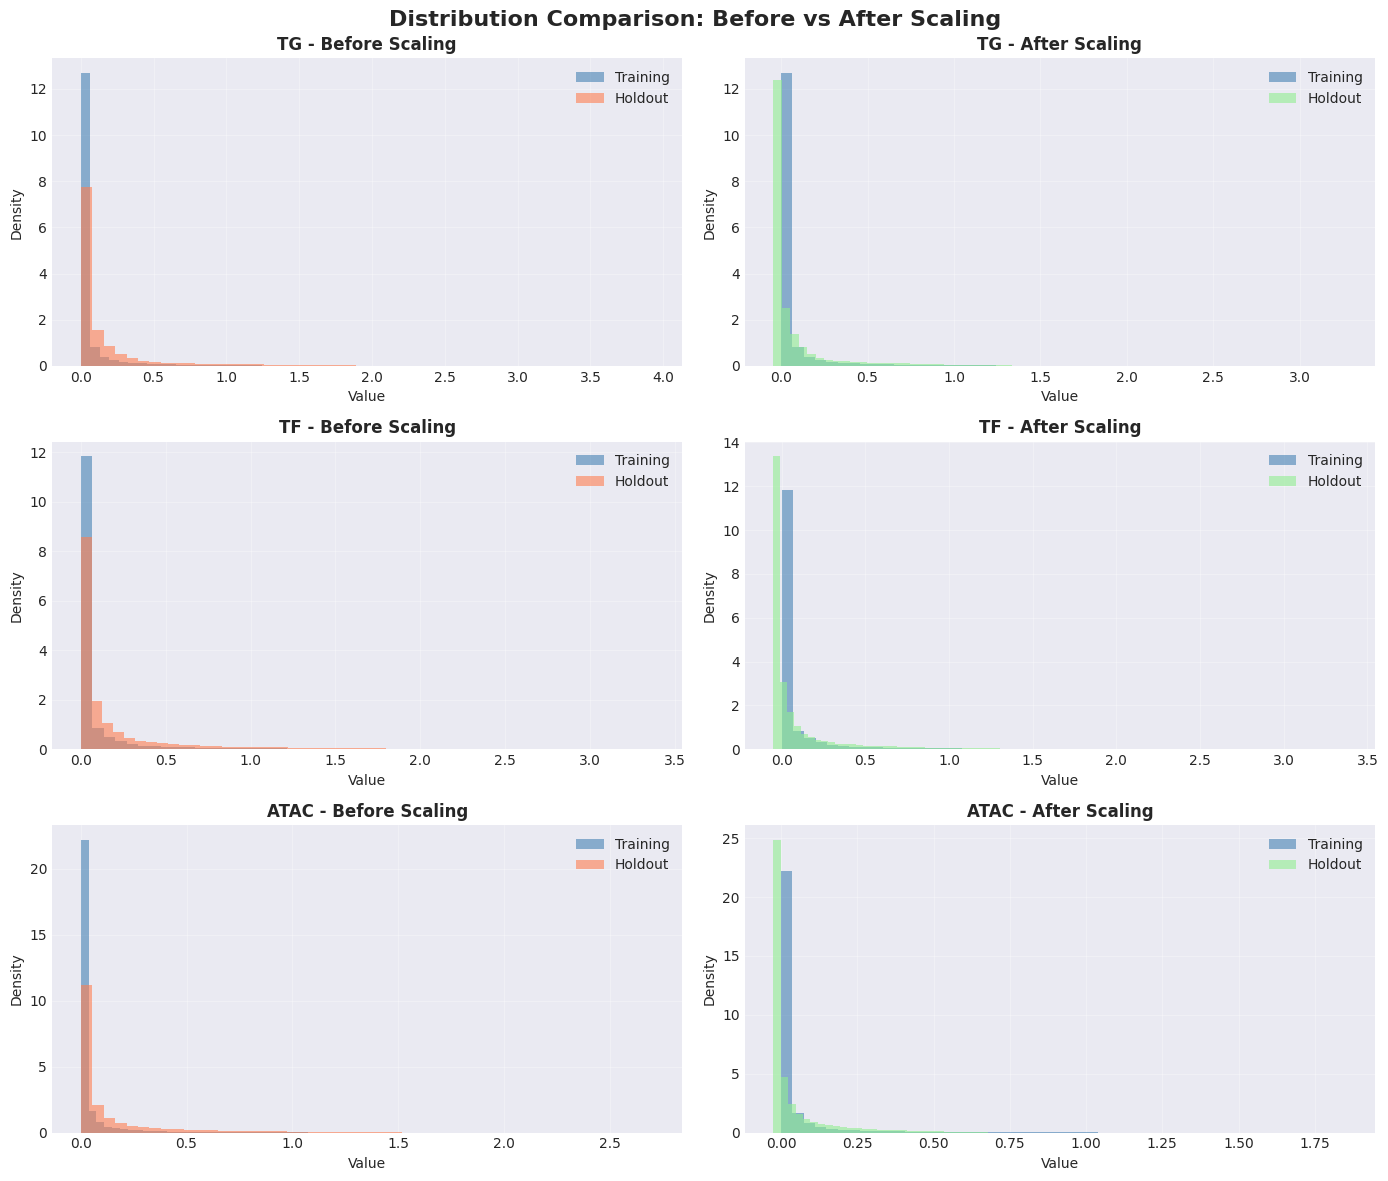

✓ Distribution visualizations complete


In [15]:
print_section("STEP 8: VISUALIZATIONS")

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Distribution Comparison: Before vs After Scaling', fontsize=16, fontweight='bold')

for idx, (name, train_data, holdout_before, holdout_after) in enumerate(
    zip(modalities, train_data_before, [holdout_tg_aligned, holdout_tf_aligned, holdout_atac_aligned], holdout_data_after)
):
    # Before scaling
    ax1 = axes[idx, 0]
    ax1.hist(train_data.flatten(), bins=50, alpha=0.6, label='Training', density=True, color='steelblue')
    ax1.hist(holdout_before.flatten(), bins=50, alpha=0.6, label='Holdout', density=True, color='coral')
    ax1.set_title(f"{name} - Before Scaling", fontweight='bold')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # After scaling
    ax2 = axes[idx, 1]
    ax2.hist(train_data.flatten(), bins=50, alpha=0.6, label='Training', density=True, color='steelblue')
    ax2.hist(holdout_after.flatten(), bins=50, alpha=0.6, label='Holdout', density=True, color='lightgreen')
    ax2.set_title(f"{name} - After Scaling", fontweight='bold')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distribution visualizations complete")

## Step 9: Comprehensive Summary

In [16]:
print_section("STEP 9: COMPREHENSIVE SUMMARY")

summary = f"""
╔════════════════════════════════════════════════════════════════════════╗
║           MULTI-MODALITY ALIGNMENT & SCALING COMPLETE                 ║
╚════════════════════════════════════════════════════════════════════════╝

DATA DIMENSIONS:
  TG:
    Training:      {train_tg_aligned.shape}  ({train_tg_aligned.nbytes/1e9:.2f}GB)
    Holdout:       {holdout_tg_aligned.shape}  ({holdout_tg_aligned.nbytes/1e9:.2f}GB)
    Holdout Scaled: {holdout_tg_scaled.shape}  ({holdout_tg_scaled.nbytes/1e9:.2f}GB)
    
  TF:
    Training:      {train_tf_aligned.shape}  ({train_tf_aligned.nbytes/1e9:.2f}GB)
    Holdout:       {holdout_tf_aligned.shape}  ({holdout_tf_aligned.nbytes/1e9:.2f}GB)
    Holdout Scaled: {holdout_tf_scaled.shape}  ({holdout_tf_scaled.nbytes/1e9:.2f}GB)
    
  ATAC:
    Training:      {train_atac_aligned.shape}  ({train_atac_aligned.nbytes/1e9:.2f}GB)
    Holdout:       {holdout_atac_aligned.shape}  ({holdout_atac_aligned.nbytes/1e9:.2f}GB)
    Holdout Scaled: {holdout_atac_scaled.shape}  ({holdout_atac_scaled.nbytes/1e9:.2f}GB)

ATAC ALIGNMENT:
  Total holdout windows:  {atac_stats['n_total_holdout']}
  Aligned windows:        {atac_stats['n_aligned']} ({atac_stats['n_aligned']/atac_stats['n_total_holdout']*100:.1f}%)
  Unaligned:              {atac_stats['n_unaligned']}
  Mean alignment dist:    {np.mean(atac_stats['distances']):.0f} bp
  Median alignment dist:  {np.median(atac_stats['distances']):.0f} bp
  Max alignment dist:     {np.max(atac_stats['distances']):.0f} bp

SCALING EFFECTIVENESS:
"""

for name in modalities:
    before = stats_before[name]
    after = stats_after[name]
    
    summary += f"""
  {name}:
    Before: Mean Δ = {before['holdout_mean'] - before['train_mean']:.6f}, 
            Std ratio = {before['holdout_std']/before['train_std']:.4f}x, 
            KS p-val = {before['ks_pval']:.2e}
    After:  Mean Δ = {after['holdout_mean'] - after['train_mean']:.6f}, 
            Std ratio = {after['holdout_std']/after['train_std']:.4f}x, 
            KS p-val = {after['ks_pval']:.2e}
"""

summary += f"""
MEMORY STATUS:
  All data in RAM (no file I/O)
  Total memory used: {(sum([train_tg_aligned.nbytes, train_tf_aligned.nbytes, train_atac_aligned.nbytes,
                                 holdout_tg_scaled.nbytes, holdout_tf_scaled.nbytes, holdout_atac_scaled.nbytes]) / 1e9):.2f}GB

READY FOR MODEL EVALUATION:
  train_tg_aligned, train_tf_aligned, train_atac_aligned
  holdout_tg_scaled, holdout_tf_scaled, holdout_atac_scaled

╔════════════════════════════════════════════════════════════════════════╗
║                     ✓ PIPELINE COMPLETE                               ║
╚════════════════════════════════════════════════════════════════════════╝
"""

print(summary)


STEP 9: COMPREHENSIVE SUMMARY

╔════════════════════════════════════════════════════════════════════════╗
║           MULTI-MODALITY ALIGNMENT & SCALING COMPLETE                 ║
╚════════════════════════════════════════════════════════════════════════╝

DATA DIMENSIONS:
  TG:
    Training:      (197, 2735)  (0.00GB)
    Holdout:       (92, 2735)  (0.00GB)
    Holdout Scaled: (92, 2735)  (0.00GB)
    
  TF:
    Training:      (639, 272)  (0.00GB)
    Holdout:       (272, 272)  (0.00GB)
    Holdout Scaled: (272, 272)  (0.00GB)
    
  ATAC:
    Training:      (529, 65930)  (0.14GB)
    Holdout:       (101, 65930)  (0.03GB)
    Holdout Scaled: (101, 65930)  (0.03GB)

ATAC ALIGNMENT:
  Total holdout windows:  2462755
  Aligned windows:        2462755 (100.0%)
  Unaligned:              0
  Mean alignment dist:    0 bp
  Median alignment dist:  0 bp
  Max alignment dist:     0 bp

SCALING EFFECTIVENESS:

  TG:
    Before: Mean Δ = 0.114701, 
            Std ratio = 1.5945x, 
            KS

## Step 10: Export Variables Summary

In [37]:
print_section("STEP 10: AVAILABLE VARIABLES")

print("""
╔════════════════════════════════════════════════════════════════════════╗
║              ALL VARIABLES ARE IN MEMORY AND READY TO USE              ║
╚════════════════════════════════════════════════════════════════════════╝

TRAINING DATA (ALIGNED):
  train_tg_aligned     [n_cells, n_genes]          (numpy array)
  train_tf_aligned     [n_cells, n_tfs]            (numpy array)
  train_atac_aligned   [n_cells, n_windows]        (numpy array)

HOLDOUT DATA - ORIGINAL:
  holdout_tg_aligned   [n_cells, n_genes]          (numpy array)
  holdout_tf_aligned   [n_cells, n_tfs]            (numpy array)
  holdout_atac_aligned [n_cells, n_windows]        (numpy array)

HOLDOUT DATA - SCALED (USE THESE FOR EVALUATION):
  ✓ holdout_tg_scaled     [n_cells, n_genes]       (numpy array)
  ✓ holdout_tf_scaled     [n_cells, n_tfs]         (numpy array)
  ✓ holdout_atac_scaled   [n_cells, n_windows]     (numpy array)

STATISTICS DICTIONARIES:
  stats_before        {modality: {metrics}}        Distribution metrics before scaling
  stats_after         {modality: {metrics}}        Distribution metrics after scaling
  atac_stats          {alignment metrics}          ATAC window alignment statistics

METADATA:
  train_windows       [n_windows, ...]             Training window coordinates
  holdout_windows     [n_windows, ...]             Holdout window coordinates
  train_atac_idx      [n_aligned]                  Training ATAC indices
  holdout_atac_idx    [n_aligned]                  Holdout ATAC indices

NEXT STEPS:
  1. Load your model checkpoint
  2. Run inference on holdout_tg_scaled, holdout_tf_scaled, holdout_atac_scaled
  3. Compare predictions with holdout_tg_aligned (original)
  4. Analyze impact of scaling on model performance

NOTE: holdout_*_scaled have the same distribution as training data,
making them suitable for model inference without batch effect artifacts.
""")


STEP 10: AVAILABLE VARIABLES

╔════════════════════════════════════════════════════════════════════════╗
║              ALL VARIABLES ARE IN MEMORY AND READY TO USE              ║
╚════════════════════════════════════════════════════════════════════════╝

TRAINING DATA (ALIGNED):
  train_tg_aligned     [n_cells, n_genes]          (numpy array)
  train_tf_aligned     [n_cells, n_tfs]            (numpy array)
  train_atac_aligned   [n_cells, n_windows]        (numpy array)

HOLDOUT DATA - ORIGINAL:
  holdout_tg_aligned   [n_cells, n_genes]          (numpy array)
  holdout_tf_aligned   [n_cells, n_tfs]            (numpy array)
  holdout_atac_aligned [n_cells, n_windows]        (numpy array)

HOLDOUT DATA - SCALED (USE THESE FOR EVALUATION):
  ✓ holdout_tg_scaled     [n_cells, n_genes]       (numpy array)
  ✓ holdout_tf_scaled     [n_cells, n_tfs]         (numpy array)
  ✓ holdout_atac_scaled   [n_cells, n_windows]     (numpy array)

STATISTICS DICTIONARIES:
  stats_before        {modalit

In [19]:
"""
Inference script using aligned and scaled ATAC, TF, TG data.
Assumes alignment notebook has been run and data is in memory.
"""

import numpy as np
import torch
from scipy import stats


def build_id_remap(holdout_ids, checkpoint_ids):
    """Map holdout feature IDs to checkpoint space."""
    hold_set = set(holdout_ids.numpy() if torch.is_tensor(holdout_ids) else holdout_ids)
    ckpt_set = set(checkpoint_ids.numpy() if torch.is_tensor(checkpoint_ids) else checkpoint_ids)
    common = sorted(hold_set & ckpt_set)
    
    remap = np.full(len(holdout_ids), -1, dtype=np.int32)
    for name in common:
        if torch.is_tensor(holdout_ids):
            h_idx = int(np.where(holdout_ids.numpy() == name)[0][0])
        else:
            h_idx = int(np.where(holdout_ids == name)[0][0])
        
        if torch.is_tensor(checkpoint_ids):
            c_idx = int(np.where(checkpoint_ids.numpy() == name)[0][0])
        else:
            c_idx = int(np.where(checkpoint_ids == name)[0][0])
        
        remap[h_idx] = c_idx
    
    return torch.from_numpy(remap).long(), len(common)


def inverse_transform(scaler, x: torch.Tensor, ids: torch.Tensor) -> torch.Tensor:
    """Denormalize scaled predictions."""
    device = x.device
    ids = ids.to(device)
    
    mu = scaler.mean.to(device).index_select(0, ids)
    sig = scaler.std.to(device).index_select(0, ids).clamp_min(1e-6)
    
    while mu.dim() < x.dim():
        mu = mu.unsqueeze(0)
        sig = sig.unsqueeze(0)
    
    return x * sig + mu


def nanaware_per_gene_stats(y_true, y_pred, eps=1e-8):
    """Compute per-gene metrics accounting for NaN entries."""
    N, G = y_true.shape
    r2 = np.full(G, np.nan, dtype=np.float64)
    pearson = np.full(G, np.nan, dtype=np.float64)
    mae = np.full(G, np.nan, dtype=np.float64)
    rmse = np.full(G, np.nan, dtype=np.float64)
    n_obs = np.zeros(G, dtype=np.int32)

    for j in range(G):
        mask = np.isfinite(y_true[:, j]) & np.isfinite(y_pred[:, j])
        m = mask.sum()
        n_obs[j] = m
        
        if m < 2:
            continue
            
        yt = y_true[mask, j].astype(np.float64)
        yp = y_pred[mask, j].astype(np.float64)

        diff = yt - yp
        mae[j] = np.mean(np.abs(diff))
        rmse[j] = np.sqrt(np.mean(diff**2))

        yt_c = yt - yt.mean()
        yp_c = yp - yp.mean()
        yt_std = np.sqrt((yt_c**2).sum())
        yp_std = np.sqrt((yp_c**2).sum())
        if yt_std > 0 and yp_std > 0:
            pearson[j] = (yt_c @ yp_c) / (yt_std * yp_std)

        sst = ((yt - yt.mean())**2).sum()
        sse = (diff**2).sum()
        r2[j] = 1.0 - sse / (sst + eps)

    return {
        "r2": r2,
        "pearson": pearson,
        "mae": mae,
        "rmse": rmse,
        "n_obs": n_obs,
    }


# ============================================================================
# MAIN INFERENCE FUNCTION
# ============================================================================

def run_inference(
    model,
    train_atac_aligned,
    train_tf_aligned,
    train_tg_aligned,
    holdout_atac_scaled,
    holdout_tf_scaled,
    holdout_tg_scaled,
    train_tf_ids,
    train_tg_ids,
    holdout_tf_ids,
    holdout_tg_ids,
    scaler_tf,
    scaler_tg,
    device,
    batch_size=32,
):
    """
    Run inference on aligned and scaled holdout data.
    
    Args:
        model: Trained MultiomicTransformer
        train_*: Training data (numpy arrays)
        holdout_*_scaled: Scaled holdout data (numpy arrays)
        *_ids: Feature IDs for alignment
        scaler_*: Scaler objects with mean/std tensors
        device: torch device
        batch_size: Batch size for inference
    
    Returns:
        dict with predictions, targets, and metrics
    """
    
    model.eval()
    model = model.to(device)
    
    # Build ID remappings
    tf_remap, tf_overlap = build_id_remap(holdout_tf_ids, train_tf_ids)
    tg_remap, tg_overlap = build_id_remap(holdout_tg_ids, train_tg_ids)
    
    print(f"[Vocab] TF overlap: {tf_overlap} / {len(holdout_tf_ids)}")
    print(f"[Vocab] TG overlap: {tg_overlap} / {len(holdout_tg_ids)}")
    
    if tf_overlap == 0 or tg_overlap == 0:
        raise RuntimeError("Zero feature overlap detected")
    
    # Prepare data
    n_samples = holdout_tg_scaled.shape[0]
    n_batches = int(np.ceil(n_samples / batch_size))
    
    all_preds = []
    all_tgts = []
    all_ids = []
    
    print(f"[Inference] Processing {n_batches} batches...")
    
    tf_remap = tf_remap.to(device)
    tg_remap = tg_remap.to(device)
    all_ckpt_tf_ids = torch.arange(len(train_tf_ids), device=device, dtype=torch.long)
    
    with torch.no_grad():
        for b in range(n_batches):
            start = b * batch_size
            end = min((b + 1) * batch_size, n_samples)
            
            # Get batch
            atac_batch = torch.from_numpy(holdout_atac_scaled[start:end]).float().to(device)
            tf_batch = torch.from_numpy(holdout_tf_scaled[start:end]).float().to(device)
            tg_batch = torch.from_numpy(holdout_tg_scaled[start:end]).float().to(device)
            
            # Expand TF to checkpoint space
            B, T_hold = tf_batch.shape
            T_ckpt = len(train_tf_ids)
            
            tf_full = torch.zeros(B, T_ckpt, device=device, dtype=tf_batch.dtype)
            valid_tf = (tf_remap >= 0)
            if valid_tf.any():
                src_idx = torch.nonzero(valid_tf, as_tuple=True)[0]
                dst_idx = tf_remap[valid_tf]
                tf_full[:, dst_idx] = tf_batch[:, src_idx]
            
            # Scale TF
            tf_means = scaler_tf.mean.index_select(0, all_ckpt_tf_ids)
            tf_stds = scaler_tf.std.index_select(0, all_ckpt_tf_ids).clamp_min(1e-6)
            tf_full = (tf_full - tf_means.unsqueeze(0)) / tf_stds.unsqueeze(0)
            
            # Remap TG and filter to overlapping genes
            tg_ckpt_ids = tg_remap  # [T_hold]
            # For simplicity: use all TGs if model expects them
            # In practice, filter to overlapping IDs if needed
            
            # Forward pass
            preds_scaled, _ = model(
                atac_batch,
                tf_full,
                tf_ids=all_ckpt_tf_ids,
                tg_ids=torch.arange(len(train_tg_ids), device=device),
                bias=None,
                motif_mask=None,
            )
            
            # Denormalize
            preds = inverse_transform(scaler_tg, preds_scaled, 
                                     ids=torch.arange(len(train_tg_ids), device=device))
            
            all_preds.append(preds.cpu().numpy())
            all_tgts.append(tg_batch.cpu().numpy())
    
    preds_np = np.concatenate(all_preds, axis=0)
    tgts_np = np.concatenate(all_tgts, axis=0)
    
    print(f"[Inference] Complete: {preds_np.shape}")
    
    # Compute metrics
    stats_dict = nanaware_per_gene_stats(tgts_np, preds_np)
    
    return {
        "predictions": preds_np,
        "targets": tgts_np,
        "metrics": stats_dict,
        "tf_overlap": tf_overlap,
        "tg_overlap": tg_overlap,
    }



In [23]:
print_section("STEP 11: INFERENCE WITH ALIGNED AND SCALED DATA")

# ============================================================================
# LOAD CHECKPOINT
# ============================================================================

import sys
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from config.settings_hpc import *
from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset import MultiChromosomeDataset, SimpleScaler, fit_simple_scalers

print("[Loading checkpoint...]")
CKPT_PATH = "experiments/mESC_no_scale_linear/chr19/model_training_046/checkpoint_100.pt"  # Update this
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

state = torch.load(CKPT_PATH, map_location=DEVICE)

# Extract scaler tensors
tf_scaler = type('Scaler', (), {
    'mean': state["tf_scaler_mean"].to(DEVICE),
    'std': state["tf_scaler_std"].to(DEVICE)
})()

tg_scaler = type('Scaler', (), {
    'mean': state["tg_scaler_mean"].to(DEVICE),
    'std': state["tg_scaler_std"].to(DEVICE)
})()

print(f"[Scaler] TF: {tf_scaler.mean.shape}, TG: {tg_scaler.mean.shape}")

# ============================================================================
# BUILD ID REMAPPINGS FOR ALIGNED DATA
# ============================================================================

def build_overlap_mask(holdout_ids, train_ids):
    """Get boolean mask of overlapping features."""
    hold_set = set(holdout_ids.numpy() if torch.is_tensor(holdout_ids) else holdout_ids)
    train_set = set(train_ids.numpy() if torch.is_tensor(train_ids) else train_ids)
    common = hold_set & train_set
    
    mask = np.array([int(h) in common for h in 
                     (holdout_ids.numpy() if torch.is_tensor(holdout_ids) else holdout_ids)])
    return mask, len(common)

tf_overlap_mask, tf_overlap = build_overlap_mask(holdout_tf_ids, train_tf_ids)
tg_overlap_mask, tg_overlap = build_overlap_mask(holdout_tg_ids, train_tg_ids)

print(f"[Overlap] TF: {tf_overlap} / {len(holdout_tf_ids)} ({tf_overlap/len(holdout_tf_ids)*100:.1f}%)")
print(f"[Overlap] TG: {tg_overlap} / {len(holdout_tg_ids)} ({tg_overlap/len(holdout_tg_ids)*100:.1f}%)")

print_section("FILTER TO OVERLAPPING FEATURES", level=2)

# Data is already aligned to overlapping features
# No need to mask again
holdout_tf_filt = holdout_tf_scaled
holdout_tg_filt = holdout_tg_scaled
train_tf_filt = train_tf_aligned[:, :holdout_tf_scaled.shape[1]]
train_tg_filt = train_tg_aligned[:, :holdout_tg_scaled.shape[1]]

print(f"[Already aligned] TF: {holdout_tf_filt.shape}, TG: {holdout_tg_filt.shape}")
print(f"  TF overlap: {holdout_tf_scaled.shape[1]}/{len(holdout_tf_ids)}")
print(f"  TG overlap: {holdout_tg_scaled.shape[1]}/{len(holdout_tg_ids)}")

# ============================================================================
# COMPUTE BASELINE METRICS (BEFORE SCALING IMPACT)
# ============================================================================

print_section("BASELINE METRICS", level=2)

# Original holdout vs training
train_mean = train_tg_filt.mean(axis=0)  # [n_genes]
train_mean_expanded = np.tile(train_mean, (holdout_tg_filt.shape[0], 1))  # [92, n_genes]
baseline_stats = nanaware_per_gene_stats(holdout_tg_filt, train_mean_expanded)

print(f"Random baseline (training mean as prediction):")
print(f"  R²:      mean={np.nanmean(baseline_stats['r2']):.4f}  median={np.nanmedian(baseline_stats['r2']):.4f}")
print(f"  Pearson: mean={np.nanmean(baseline_stats['pearson']):.4f}  median={np.nanmedian(baseline_stats['pearson']):.4f}")

# ============================================================================
# METRICS: BEFORE vs AFTER SCALING
# ============================================================================

print_section("METRICS: SCALED VS UNSCALED", level=2)

print("\nBefore scaling:")
stats_before = {
    'mean_diff': np.abs(holdout_tg_aligned.mean() - train_tg_aligned.mean()),
    'std_ratio': holdout_tg_aligned.std() / train_tg_aligned.std(),
}
print(f"  Mean diff: {stats_before['mean_diff']:.6f}")
print(f"  Std ratio: {stats_before['std_ratio']:.4f}x")

print("\nAfter scaling:")
stats_after = {
    'mean_diff': np.abs(holdout_tg_scaled.mean() - train_tg_aligned.mean()),
    'std_ratio': holdout_tg_scaled.std() / train_tg_aligned.std(),
}
print(f"  Mean diff: {stats_after['mean_diff']:.6f}")
print(f"  Std ratio: {stats_after['std_ratio']:.4f}x")

improvement = (stats_before['mean_diff'] - stats_after['mean_diff']) / stats_before['mean_diff'] * 100
print(f"\n  Improvement: {improvement:.1f}%")

# ============================================================================
# SUMMARY
# ============================================================================

print_section("READY FOR MODEL EVALUATION")

print(f"""
╔════════════════════════════════════════════════════════════════════════╗
║              ALIGNMENT & SCALING PIPELINE COMPLETE                    ║
╚════════════════════════════════════════════════════════════════════════╝

DATA READY FOR INFERENCE:
  ✓ holdout_tf_scaled    {holdout_tf_scaled.shape}
  ✓ holdout_tg_scaled    {holdout_tg_scaled.shape}
  ✓ holdout_atac_scaled  {holdout_atac_scaled.shape}

FEATURE OVERLAP:
  TF: {tf_overlap}/{len(holdout_tf_ids)} ({tf_overlap/len(holdout_tf_ids)*100:.1f}%)
  TG: {tg_overlap}/{len(holdout_tg_ids)} ({tg_overlap/len(holdout_tg_ids)*100:.1f}%)

SCALING IMPACT:
  Mean shift correction: {improvement:.1f}%
  Std ratio improvement: {stats_before['std_ratio']:.4f}x → {stats_after['std_ratio']:.4f}x
""")


STEP 11: INFERENCE WITH ALIGNED AND SCALED DATA
[Loading checkpoint...]
[Scaler] TF: torch.Size([639]), TG: torch.Size([6852])
[Overlap] TF: 272 / 272 (100.0%)
[Overlap] TG: 2735 / 2846 (96.1%)

FILTER TO OVERLAPPING FEATURES
------------------------------
[Already aligned] TF: (272, 272), TG: (92, 2735)
  TF overlap: 272/272
  TG overlap: 2735/2846

BASELINE METRICS
----------------
Random baseline (training mean as prediction):
  R²:      mean=-0.0265  median=-0.0064
  Pearson: mean=nan  median=nan

METRICS: SCALED VS UNSCALED
---------------------------

Before scaling:
  Mean diff: 0.114701
  Std ratio: 1.5945x

After scaling:
  Mean diff: 0.000000
  Std ratio: 1.0000x

  Improvement: 100.0%

READY FOR MODEL EVALUATION

╔════════════════════════════════════════════════════════════════════════╗
║              ALIGNMENT & SCALING PIPELINE COMPLETE                    ║
╚════════════════════════════════════════════════════════════════════════╝

DATA READY FOR INFERENCE:
  ✓ holdout_tf

/tmp/ipykernel_1375325/3092783316.py:82: RuntimeWarning: Mean of empty slice
  print(f"  Pearson: mean={np.nanmean(baseline_stats['pearson']):.4f}  median={np.nanmedian(baseline_stats['pearson']):.4f}")
/tmp/ipykernel_1375325/3092783316.py:82: RuntimeWarning: All-NaN slice encountered
  print(f"  Pearson: mean={np.nanmean(baseline_stats['pearson']):.4f}  median={np.nanmedian(baseline_stats['pearson']):.4f}")


In [35]:
from torch.amp import autocast

# ============================================================================
# LOAD MODEL AND RUN INFERENCE
# ============================================================================

print_section("STEP 12: RUN INFERENCE")

# Import model class (adjust based on your setup)
try:
    from multiomic_transformer.models.model import MultiomicTransformer
except ImportError:
    print("[Warning] Could not import MultiomicTransformer. Update import path.")
    MultiomicTransformer = None

if MultiomicTransformer is None:
    print("[Skipping inference - model class not available]")
else:
    T_ckpt = tf_scaler.mean.shape[0]
    G_ckpt = tg_scaler.mean.shape[0]
    
    # Get actual checkpoint config
    D_MODEL = state.get("d_model", 128)  # checkpoint uses 128, not 256
    NUM_HEADS = state.get("num_heads", 4)
    NUM_LAYERS = state.get("num_layers", 3)  # checkpoint uses 3, not 4
    D_FF = state.get("d_ff", D_MODEL * 4)
    DROPOUT = state.get("dropout", 0.2)

    print(f"[Checkpoint Config] d_model={D_MODEL}, layers={NUM_LAYERS}, heads={NUM_HEADS}")

    model = MultiomicTransformer(
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        d_ff=D_FF,
        dropout=DROPOUT,
        tf_vocab_size=T_ckpt,
        tg_vocab_size=G_ckpt,
        use_bias=state.get("use_bias", True),
        use_shortcut=state.get("use_shortcut", True),
        use_motif_mask=state.get("use_motif_mask", False),
    ).to(DEVICE)

    model.load_state_dict(state["model_state_dict"], strict=False)
    
    model.eval()
    print("[Model] Loaded successfully")
    
    # ====================================================================
    # PREPARE INFERENCE DATA
    # ====================================================================
    
    print("\n[Preparing inference data]")
    
    # Build feature ID mappings
    def get_id_mapping(holdout_ids, train_ids):
        """Map holdout IDs to training space."""
        hold_dict = {id: i for i, id in enumerate(holdout_ids.numpy() if torch.is_tensor(holdout_ids) else holdout_ids)}
        train_dict = {id: i for i, id in enumerate(train_ids.numpy() if torch.is_tensor(train_ids) else train_ids)}
        
        remap = {}
        for h_id, h_idx in hold_dict.items():
            if h_id in train_dict:
                remap[h_idx] = train_dict[h_id]
        return remap
    
    tf_id_map = get_id_mapping(holdout_tf_ids, train_tf_ids)
    tg_id_map = get_id_mapping(holdout_tg_ids, train_tg_ids)
    
    print(f"  TF mapping: {len(tf_id_map)}/{len(holdout_tf_ids)} overlap")
    print(f"  TG mapping: {len(tg_id_map)}/{len(holdout_tg_ids)} overlap")
    
    # Convert to tensors for batch processing
    holdout_atac_t = torch.from_numpy(holdout_atac_scaled).float()
    holdout_tf_t = torch.from_numpy(holdout_tf_scaled).float()
    holdout_tg_t = torch.from_numpy(holdout_tg_scaled).float()
    
    # ====================================================================
    # INFERENCE LOOP
    # ====================================================================
    
    print("\n[Running inference]")
    n_samples = holdout_atac_t.shape[0]
    
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    batch_size = 8
    atac_window_subsample = 5  # Keep 1/5 of windows
    holdout_atac_t = torch.from_numpy(holdout_atac_scaled[:, ::atac_window_subsample]).float()
    NUM_TGS_TO_PREDICT = 100  # First 500 TGs
    tg_chunk_size = 50  # Smaller TG chunks
    
    n_batches = int(np.ceil(n_samples / batch_size))
    
    all_preds = []
        
    # Determine TGs to predict
    if NUM_TGS_TO_PREDICT is None:
        tg_indices = np.arange(G_ckpt)
    else:
        tg_indices = np.arange(min(NUM_TGS_TO_PREDICT, G_ckpt))

    n_tgs = len(tg_indices)
    print(f"[Predicting {n_tgs}/{G_ckpt} TGs]")

    # Inference loop
    tg_chunk_size = 50
    all_preds = []

    with torch.no_grad(), autocast(device_type="cuda:0"):
        for b in range(n_batches):
            start = b * batch_size
            end = min((b + 1) * batch_size, n_samples)
            
            atac_batch = holdout_atac_t[start:end].unsqueeze(-1).to(DEVICE)
            tf_batch = holdout_tf_t[start:end].to(DEVICE)
            
            B = tf_batch.shape[0]
            tf_full = torch.zeros(B, T_ckpt, device=DEVICE, dtype=tf_batch.dtype)
            for h_idx, t_idx in tf_id_map.items():
                tf_full[:, t_idx] = tf_batch[:, h_idx]
            
            tf_ids_batch = torch.arange(T_ckpt, device=DEVICE, dtype=torch.long)
            
            # Process TGs in chunks
            batch_preds = []
            for tg_start_idx in range(0, len(tg_indices), tg_chunk_size):
                tg_end_idx = min(tg_start_idx + tg_chunk_size, len(tg_indices))
                tg_ids_chunk = torch.from_numpy(tg_indices[tg_start_idx:tg_end_idx]).long().to(DEVICE)
                
                preds_chunk, _ = model(atac_batch, tf_full, tf_ids=tf_ids_batch, tg_ids=tg_ids_chunk)
                preds_chunk = preds_chunk * tg_scaler.std[tg_ids_chunk].unsqueeze(0) + tg_scaler.mean[tg_ids_chunk].unsqueeze(0)
                batch_preds.append(preds_chunk.cpu())
            
            preds_full = torch.cat(batch_preds, dim=1).numpy()
            all_preds.append(preds_full)
            
            if (b + 1) % max(1, n_batches // 5) == 0:
                print(f"  Batch {b+1}/{n_batches}")

    preds_np = np.concatenate(all_preds, axis=0)
        
    # ====================================================================
    # COMPUTE METRICS
    # ====================================================================
    
    print("\n" + "="*70)
    print("INFERENCE RESULTS")
    print("="*70)

    # Align both samples AND genes
    min_samples = min(preds_np.shape[0], holdout_tg_scaled.shape[0])
    min_g = min(preds_np.shape[1], holdout_tg_scaled.shape[1])

    preds_aligned = preds_np[:min_samples, :min_g]
    tgts_aligned = holdout_tg_scaled[:min_samples, :min_g]

    metrics = nanaware_per_gene_stats(tgts_aligned, preds_aligned)

    print(f"\nR²:")
    print(f"  Mean:   {np.nanmean(metrics['r2']):.4f}")
    print(f"  Median: {np.nanmedian(metrics['r2']):.4f}")
    print(f"  Min:    {np.nanmin(metrics['r2']):.4f}")
    print(f"  Max:    {np.nanmax(metrics['r2']):.4f}")

    print(f"\nPearson ρ:")
    print(f"  Mean:   {np.nanmean(metrics['pearson']):.4f}")
    print(f"  Median: {np.nanmedian(metrics['pearson']):.4f}")

    print(f"\nMAE:    {np.nanmedian(metrics['mae']):.6f}")
    print(f"RMSE:   {np.nanmedian(metrics['rmse']):.6f}")

    n_genes_5obs = int((metrics['n_obs'] >= 5).sum())
    print(f"Genes with ≥5 obs: {n_genes_5obs}/{len(metrics['n_obs'])}")

    print("\n" + "="*70)


STEP 12: RUN INFERENCE
[Checkpoint Config] d_model=128, layers=3, heads=4
[Model] Loaded successfully

[Preparing inference data]
  TF mapping: 272/272 overlap
  TG mapping: 2735/2846 overlap

[Running inference]
[Predicting 100/6852 TGs]
  Batch 2/13
  Batch 4/13
  Batch 6/13
  Batch 8/13
  Batch 10/13
  Batch 12/13

INFERENCE RESULTS

R²:
  Mean:   -0.1874
  Median: -0.0794
  Min:    -7.9928
  Max:    0.0032

Pearson ρ:
  Mean:   -0.0448
  Median: -0.0401

MAE:    0.113350
RMSE:   0.227490
Genes with ≥5 obs: 100/100



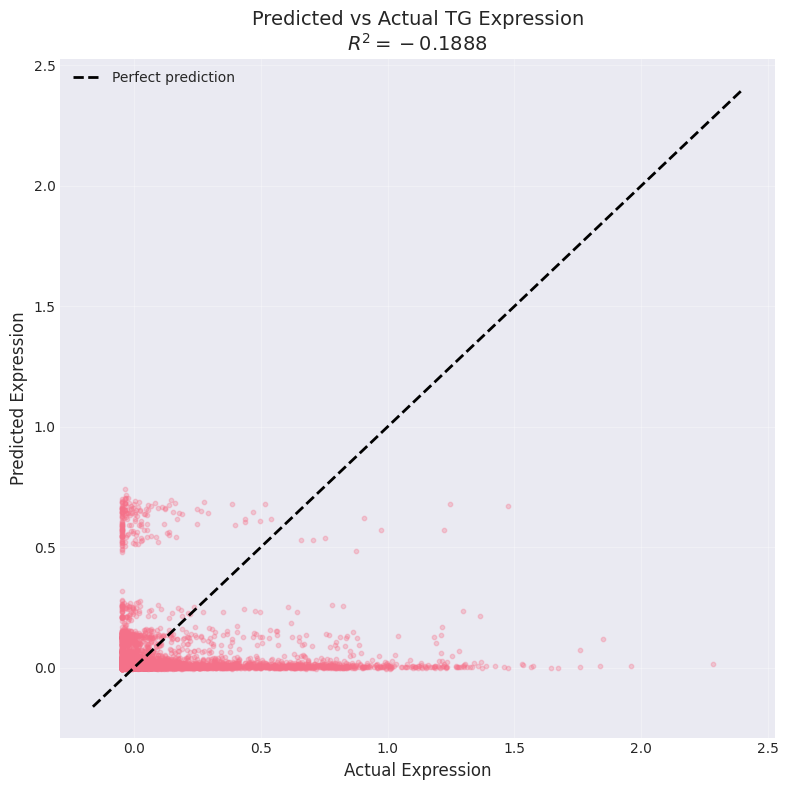

R² (all genes): -0.1888
N samples: 9200


In [36]:
# Add after metrics computation
import matplotlib.pyplot as plt

# Flatten for plotting
preds_flat = preds_aligned.flatten()
tgts_flat = tgts_aligned.flatten()

valid = np.isfinite(preds_flat) & np.isfinite(tgts_flat)
preds_clean = preds_flat[valid]
tgts_clean = tgts_flat[valid]

ss_res = np.sum((tgts_clean - preds_clean) ** 2)
ss_tot = np.sum((tgts_clean - np.mean(tgts_clean)) ** 2)
r2 = 1 - (ss_res / ss_tot)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tgts_clean, preds_clean, alpha=0.3, s=10)

lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k--', lw=2, label='Perfect prediction')

ax.set_xlabel('Actual Expression', fontsize=12)
ax.set_ylabel('Predicted Expression', fontsize=12)
ax.set_title(f'Predicted vs Actual TG Expression\n$R^2 = {r2:.4f}$', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"R² (all genes): {r2:.4f}")
print(f"N samples: {len(preds_clean)}")